In [4]:
import math
import warnings
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as anim
from numba import njit,jit


@njit
def initialize_plane(N):
    """initializes a matrix of zeros where the top row is 1"""

    #matrix of zeros of NxN
    plane = np.zeros((N,N))

    #first row contains ones
    plane[0] = np.ones(N)

    return plane

@njit
def initialize_sinks(N,sinks=0):
    """initializes a matrix of zeros where some areas are 1"""

    #plane of zeros 
    plane = np.zeros((N,N))

    #determine dimension of sink
    sink_size = int(N/10)

    #add one sink into the plane
    if sinks == 1:
        #sink in the middle of the plane
        plane[sink_size*4:sink_size*6,sink_size*4:sink_size*6] = 1
    
    #add two sinks into the plane
    if sinks == 2:
        plane[sink_size*6:sink_size*7,sink_size*7:sink_size*8] = 1
        plane[sink_size*2:sink_size*3,sink_size*2:sink_size*3] = 1
    
    return plane

@njit
def initialize_aggregate(N):
    """initializes a matrix of zeros where one cell on the bottom is 1"""

    #plane of zeros 
    plane = np.zeros((N,N))

    i = N-1
    j = int(N/2)
    #add the seed to the plane
    plane[i][j] = 1

    #add neighbors to the plane
    plane = update_candidates(plane,i,j)

    return plane

@njit
def update_candidates(aggregate,i,j):
    """defines the neighborhood for a given point,
     taking into account existing objects and boundary conditions
     """

    #add given indices to the aggregate
    aggregate[i][j] =1

    #get boundary
    N = len(aggregate)

    #check for left column boundary
    if j==0:
        #check left available
        if aggregate[i,N-1] == 0:
            aggregate[i,N-1] = .5
        #check right available
        if aggregate[i,j+1] == 0:
            aggregate[i,j+1] = .5

    #check for right column boundary
    elif j == N-1:
        #check left available
        if aggregate[i,j-1] == 0:
            aggregate[i,j-1] = .5
        #check right available
        if aggregate[i,0] == 0:
            aggregate[i,0] = .5

    #use normal neighbors      
    else:
        #check left available
        if aggregate[i,j-1] == 0:
            aggregate[i,j-1] = .5
        #check right available
        if aggregate[i,j+1] == 0:
            aggregate[i,j+1] = .5

    #check for upper row boundary
    if i==0:
        #check if down available
        if aggregate[i+1,j] == 0:
            aggregate[i+1,j] = 0.5

    #check for lower boundary
    elif i == N-1:
        #check if up available
        if aggregate[i-1,j] == 0:
            aggregate[i-1,j] = .5

    #use normal neighbors    
    else:
        #check if up available
        if aggregate[i-1,j] == 0:
            aggregate[i-1,j] = .5
        #check if down available
        if aggregate[i+1,j] == 0:
            aggregate[i+1,j] = .5

    return aggregate

@njit
def succesive_over_relaxation(state,sinks,aggregate,mix):
    """performs one iteration of the Succesive Over Relaxation method
    Given an initial state and mix term omega returns the new state of the system
    """

    #create an empty matrix for storing new values
    next_state = initialize_plane(len(state))

    #loop through columns
    for i in range(1,len(state)-1):
    
        #loop trough rows (skip first and last one)
        for j in range(len(state)):

            #check for sinks
            if sinks[i][j]==1:
                next_state[i][j] = 0

            #check for aggregate
            elif aggregate[i][j]==1:
                next_state[i][j] = 0

            #do normal update    
            else:
                #check for boundaries
                if j == 0:
                    
                    #take values on the right border of the plane
                    left = state[i][-1]
                    right = state[i][j+1]
                    
                elif j == len(state)-1:
                    
                    #take values on the left border of the plane
                    left = next_state[i][j-1]
                    right = state[i][0]
                    
                else:
                    
                    #take direct left and right neighbors
                    left = next_state[i][j-1]
                    right= state[i][j+1]

                #get direct up and down neighbors
                down = state[i+1][j]
                up = next_state[i-1][j]

                #calculate value of current cell
                next_state[i][j] = mix/4*(right+left+down+up)+((1-mix)*state[i][j])
        
    return next_state

@njit
def solve_diffusion(state,sinks,aggregate,mix=1.85,tolerance=10**-5):
    """solves the time independent diffusion equation using
    Succesive Over Relaxation. Given some initial state, mix term omega, tolerance level epsilon and location of sinks,
    Returns the equilibrium state of the sytem"""

    #initialize change as something rel. large
    change = 1.0

    #set count for number of iterations
    count = 0

    #set first state
    new_state = state

    #run until change is small
    while change>tolerance:

        #save the previous state for now
        prev_state = new_state

        #get new state of system
        new_state = succesive_over_relaxation(new_state,sinks,aggregate,mix)
    
        #get difference between new and old state
        difference = np.abs(np.subtract(new_state,prev_state))

        #change is max difference in state
        change = np.max(difference)
        count+=1

    return new_state


#@njit #doesn't work here because of np.where?
def extend_aggregate(diffusion_plane,aggregate,eta=1):
    """extends the aggregate by one pixel randomly based on the concentration in the diffusion plane"""
    
    #extract the location of neighbors from the aggregate
    candidates = np.where(aggregate == 0.5)

    #get the concentration at these locations
    concentrations = diffusion_plane[candidates[0],candidates[1]]

    #assure concentrations non-negative
    concentrations[concentrations<0] = 0

    #assure concentration non-NaN
    concentrations = np.nan_to_num(concentrations)

    #concentrations to the power of eta
    concentrations = concentrations**eta
    
    #convert concentration to probabilities
    probabilities = concentrations / sum(concentrations)

    #pick a random index based on concentration probabilities
    chosen = np.random.choice(np.arange(0,len(candidates[0])), p=probabilities)

    #extend the aggregate by the chosen index
    aggregate = update_candidates(aggregate,candidates[0][chosen],candidates[1][chosen])

    return aggregate


def simulate_DLA(N=100,eta=1,mix=1.85,tolerance=10**-5,num_sinks=0,seed=None):
    """runs a simulation for Diffusion Limited Aggregation
    Returns the final state of the system as diffusion field and aggregate
    """

    #set random seed for testing
    np.random.seed(seed)

    #initialize plane
    diffusion_plane = initialize_plane(N)

    #initialize sinks 
    sinks = initialize_sinks(N,num_sinks)

    #initialize aggregate
    new_aggregate = initialize_aggregate(N)

    #grow the aggregate until it has reached the source
    while np.max(new_aggregate[0]) == 0:

        #solve the diffusion 
        diffusion_plane = solve_diffusion(diffusion_plane,sinks,new_aggregate,mix,tolerance)

        #extend the agrregate based on the concetration levels
        new_aggregate = extend_aggregate(diffusion_plane,new_aggregate,eta)

    return diffusion_plane,new_aggregate

In [16]:
#run the simulation with default parameters  (Does not work for eta={0.1,0.2} --> probabilities will contain Nan)
diffusion_plane,new_aggregate = simulate_DLA(eta=1.0)

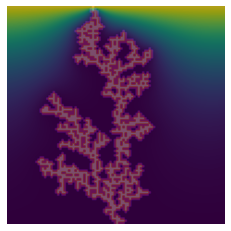

In [20]:
fig = plt.figure(frameon=False)

#plot planes on top of eachother
im1 = plt.imshow(new_aggregate, cmap=plt.cm.inferno)
im2 = plt.imshow(diffusion_plane, cmap=plt.cm.viridis, alpha=.7, interpolation='bilinear') 

#remove the axes ticks
for ax in fig.axes:
    ax.label_outer()
    ax.axis('off')

#save the plot
# plt.savefig("Figures/example.svg",format="svg", dpi=300)

# Plotting
Below we define code for plotting our experiments. The experiments we plot are:

### Diffusion Limited Aggregation -DLA
* plot the simulation for different values of $\eta$
    * show the growth of the aggregate at different timesteps for a single $\eta$. (i.e. $\eta=1$)
    * show different realisations of multiple $\eta$. (i.e 3 simulations of $\eta=0$, 3 for $\eta=0.5$ etc. $\eta$= [0.0,0.5,1.0,1.5,2.0])
* find optimal values for $\omega$
* show the effect of optimization
* Make an animated plot of the growth of the aggregate

### Monte Carlo - DLA-MC
* Compare the resulting cluster of MC to DLA
* Plot the influence of $P_s$ on the cluster
* Make an animated plot of the time development

### Gray Scott
* Plot the resulting concentrations for several values of $V$ and $U$. Base case: δt=1, δx=1, Du=0.16, Dv=0.08, f=0.035, k=0.060.

# DLA

### Different $\eta$